# Pneumonia Classifier - DenseNet201

In [10]:
# Import libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

# Check TensorFlow version
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.14.0


In [11]:
# Check if physical GPU device detected
gpu_devices = tf.config.list_physical_devices('GPU')
if not len(gpu_devices):
    print('No GPUs detected!')
else:
    print(len(gpu_devices), 'GPUs found!')
    print(gpu_devices)

1 GPUs found!
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [12]:
# Setup Environment
dataset_base_dir = '../Dataset/chest_xray_resized/'
train_data_dir = 'train'
valid_data_dir = 'valid'
test_data_dir = 'test'
models_dir = './models'

In [13]:
# Image Data Generators

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = image_gen = ImageDataGenerator(rotation_range=20, # rotate the image 20 degrees
                               width_shift_range=0.05, # Shift the pic width by a max of 5%
                               height_shift_range=0.05, # Shift the pic height by a max of 5%
                               rescale=1/255, # Rescale the image by normalzing it.
                               shear_range=0.1, # Shear means cutting away part of the image (max 10%)
                               zoom_range=0.1, # Zoom in by 10% max
                               horizontal_flip=True, # Allo horizontal flipping
                               fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                              )

test_datagen = image_gen = ImageDataGenerator(rotation_range=20, # rotate the image 20 degrees
                               width_shift_range=0.05, # Shift the pic width by a max of 5%
                               height_shift_range=0.05, # Shift the pic height by a max of 5%
                               rescale=1/255, # Rescale the image by normalzing it.
                               shear_range=0.1, # Shear means cutting away part of the image (max 10%)
                               zoom_range=0.1, # Zoom in by 10% max
                               horizontal_flip=True, # Allo horizontal flipping
                               fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                              )

image_shape = (224, 224, 3)
batch_size = 32

In [14]:
# Data Flow with Augmentation

train_gen = train_datagen.flow_from_directory(
    os.path.join(dataset_base_dir, train_data_dir),
    target_size=image_shape[:2],
    class_mode='binary',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

valid_gen = test_datagen.flow_from_directory(
    os.path.join(dataset_base_dir, valid_data_dir), 
    target_size=image_shape[:2], 
    class_mode='binary', 
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size
)

test_gen = test_datagen.flow_from_directory(
    os.path.join(dataset_base_dir, test_data_dir), 
    target_size=image_shape[:2],
    class_mode='binary', 
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [15]:
# Train Dataset Stats - IMBALANCED (DUE TO MEDICAL)
from collections import Counter
counter = Counter(train_gen.classes)
print(counter.items())

dict_items([(0, 1341), (1, 3875)])


In [16]:
# Validation Dataset Stats - BALANCED
from collections import Counter
counter = Counter(valid_gen.classes)
print(counter.items())

dict_items([(0, 8), (1, 8)])


In [17]:
# Test Dataset Stats - BALANCED
from collections import Counter
counter = Counter(test_gen.classes)
print(counter.items())

dict_items([(0, 234), (1, 390)])


In [18]:
# Architect Model

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout, Dense, Input
from tensorflow.keras.applications.densenet import DenseNet201

base_model = DenseNet201(include_top=False,
                         input_shape=(256,256,3),
                         weights='imagenet',
                         pooling="avg"
                        )

base_model.trainable = False
image_input = Input(shape=(256, 256, 3))

x = base_model(image_input,training = False)

x = Dense(256,activation = "relu")(x)
x = Dropout(0.2)(x)

x = Dense(128,activation = "relu")(x)
x = Dropout(0.2)(x)

image_output = Dense(1,activation="sigmoid")(x)

model = Model(image_input,image_output)
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 densenet201 (Functional)    (None, 1920)              18321984  
                                                                 
 dense (Dense)               (None, 256)               491776    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 129   

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
early_stop = EarlyStopping(monitor='val_loss', patience=2, mode='auto')
checkpoint = ModelCheckpoint(filepath='./models/dn201_bestcheckpoint.h5', monitor='accuracy', save_best_only=True)
# learning_rate = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, verbose=1)

history = model.fit(train_gen, epochs=15,
          validation_data=test_gen,
          callbacks=[early_stop, checkpoint])

In [ ]:
# Save trained model weights
model.save(os.path.join(models_dir, 'dn201_pre.h5'))

In [19]:
# Evaluate the trained model
model.load_weights('./models/dn201_bestcheckpoint.h5')
eval_results = model.evaluate(test_gen)

2023-09-27 18:38:39.192384: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600


20/20 [==============================] - 21s 656ms/step - loss: 0.3757 - accuracy: 0.8478


In [20]:
# List the classes
test_gen.class_indices

{'normal': 0, 'pneumonia': 1}

In [21]:
# Take predictions using test image generator
test_dataset_prediction_probabilities = model.predict(test_gen)

20/20 [==============================] - 7s 222ms/step


In [22]:
# Argmax of Probabilities
test_dataset_predictions = [i > 0.5 for i in test_dataset_prediction_probabilities]
print(test_dataset_predictions)

[array([False]), array([False]), array([False]), array([False]), array([False]), array([False]), array([False]), array([False]), array([ True]), array([False]), array([False]), array([ True]), array([False]), array([False]), array([ True]), array([False]), array([ True]), array([False]), array([False]), array([False]), array([ True]), array([False]), array([False]), array([False]), array([False]), array([False]), array([False]), array([False]), array([ True]), array([False]), array([ True]), array([False]), array([False]), array([False]), array([ True]), array([False]), array([False]), array([False]), array([False]), array([False]), array([False]), array([False]), array([False]), array([False]), array([False]), array([ True]), array([ True]), array([False]), array([ True]), array([False]), array([False]), array([False]), array([False]), array([False]), array([False]), array([False]), array([ True]), array([False]), array([False]), array([False]), array([False]), array([ True]), array([

In [24]:
# Generate classification report
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(test_gen.classes,test_dataset_predictions))

              precision    recall  f1-score   support

           0       0.97      0.66      0.79       234
           1       0.83      0.99      0.90       390

    accuracy                           0.87       624
   macro avg       0.90      0.82      0.84       624
weighted avg       0.88      0.87      0.86       624



array([[155,  79],
       [  5, 385]])

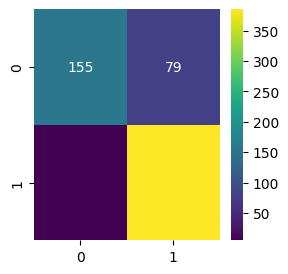

In [25]:
# Generate confusion matrix
plt.figure(figsize=(3,3))
sns.heatmap(confusion_matrix(test_gen.classes,test_dataset_predictions),annot = True, fmt = "d", cmap = "viridis")
confusion_matrix(test_gen.classes,test_dataset_predictions)

In [ ]:
# Manual Testing - Normal
from tensorflow.keras.preprocessing import image
normal_image = image.load_img('../Dataset/final/test/normal/0103fadb-1663-40a6-8a9e-09d626cd2091.png', target_size=image_shape[:2])
normal_image = np.expand_dims(normal_image, axis=1)
normal_image = normal_image.reshape(image_shape)
normal_image = normal_image / 256
plt.imshow(normal_image)
prediction = model.predict(normal_image.reshape(1, 224, 224, 3))
print(prediction[0][0] > 0.5)

In [ ]:
# Manual Testing - Pneumonia
from tensorflow.keras.preprocessing import image
positive_image = image.load_img('../Dataset/final/test/pneumonia/MIDRC-RICORD-1C-419639-000025-17477-0.png', target_size=image_shape[:2])
positive_image = np.expand_dims(positive_image, axis=1)
positive_image = positive_image.reshape(image_shape)
positive_image = positive_image / 256
plt.imshow(positive_image)
prediction = model.predict(positive_image.reshape(1, 224, 224, 3))
print(prediction[0][0] > 0.5)